In [1]:
import torch
from torch import nn   # pytroch building blocks for neural network
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Make data
import sklearn
from sklearn.datasets import make_circles

In [2]:
# Make data
sample_num = 1000
X, y = make_circles(sample_num,
                    noise = 0.04,
                    random_state = 314)

# Features in the data created
X[:5], y[:5]

(array([[-0.78086628, -0.09666288],
        [-0.96863247, -0.38734983],
        [ 0.78234703,  0.17829275],
        [-0.82821169, -0.66643094],
        [ 0.14701221,  0.98342128]]),
 array([1, 0, 1, 0, 0], dtype=int64))

In [3]:
# Convert the data to pandas dataframe
circles = pd.DataFrame({"X1": X[:,0], 
                        "X2": X[:,1],
                        "Label":y})
circles

,X1,X2,Label
0,-0.780866,-0.096663,1
1,-0.968632,-0.387350,0
2,0.782347,0.178293,1
3,-0.828212,-0.666431,0
4,0.147012,0.983421,0
...,...,...,...
995,-0.115975,-0.766357,1
996,0.654302,-0.446809,1
997,-0.698129,0.362694,1
998,0.045427,0.822557,1


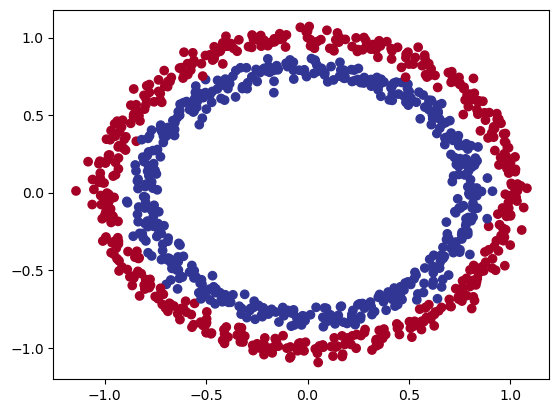

In [4]:
# Visualize the data
plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [5]:
# Convert data to tensor
X = torch.tensor(X).type(torch.float)
y = torch.tensor(y).type(torch.float)

In [6]:
# Split data to train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.25, random_state=314)

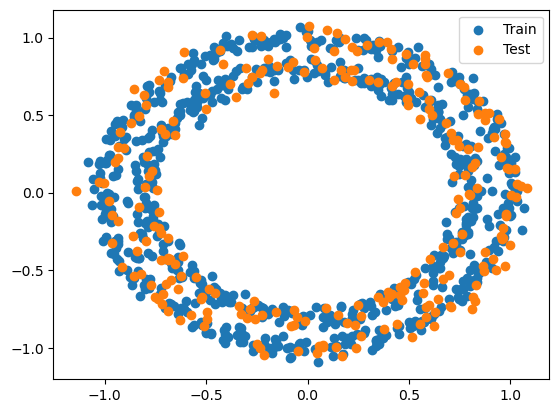

In [7]:
# Distribution of train-test data
plt.scatter(x=X_train[:, 0], y=X_train[:, 1], label="Train")
plt.scatter(x=X_test[:, 0], y=X_test[:, 1], label="Test")
plt.legend()

In [8]:
## Build a model for classification of circles

# This model is for non-linear data
class CircleClassificationModel(nn.Module):
    def __init__(self):
        super().__init__()

        # Create nn.linear layer that can handle the data
        self.layer_1 = nn.Linear(in_features=2, out_features=20) # take in two values(point coorninates) and upscale it to 20
        self.layer_2 = nn.Linear(in_features=20, out_features=20) # process 20 upscaled values
        self.layer_3 = nn.Linear(in_features=20, out_features=20) # process 20 upscaled values
        self.layer_4 = nn.Linear(in_features=20, out_features=20) # process 20 upscaled values
        self.layer_5 = nn.Linear(in_features=20, out_features=20) # process 20 upscaled values
        self.out_layer = nn.Linear(in_features=20, out_features=1) # take the 20 processed values and output one answer
        
        self.relu = nn.ReLU()# ReLu change all negative values to zero, and is a non-linear activation function

    def forward(self, X):
        X = X.float()
        return self.out_layer(self.relu(self.layer_5(self.relu(self.layer_4(self.relu(self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(X)))))))))))
    
# Random seed
torch.manual_seed(100)

model = CircleClassificationModel()

# Simpler way to set up basic model
'''
model = nn.Sequential(
    nn.Linear(in_features=2, out_features=20),
    nn.Linear(in_features=20, out_features=20),
    nn.Linear(in_features=20, out_features=20),
    nn.Linear(in_features=20, out_features=1)
)
'''

model

CircleClassificationModel(
  (layer_1): Linear(in_features=2, out_features=20, bias=True)
  (layer_2): Linear(in_features=20, out_features=20, bias=True)
  (layer_3): Linear(in_features=20, out_features=20, bias=True)
  (layer_4): Linear(in_features=20, out_features=20, bias=True)
  (layer_5): Linear(in_features=20, out_features=20, bias=True)
  (out_layer): Linear(in_features=20, out_features=1, bias=True)
  (relu): ReLU()
)

In [9]:
## Set up optimizer and loss function

# For binary classification, we can use binary cross entropy or categorical cross entropy

# In the case for classification, cross entropy is more effective that absolute/square mean error 
# As in the context of weight adjusting, the cross entropy penalize the model more for higher error values
# Since we are dealing with classification data, the model should indeed be penalized more...
    # as the values are describing catergories rather than values in a range


# Binary entropy loss with logit (logit: inverse of standard logistic distribution)
# With sigmoid activation function built in
loss_function = nn.BCEWithLogitsLoss() 

optimizer = torch.optim.SGD (params=model.parameters(),
                             lr=0.01,  # lr = learning rate, most important hyperparameter
                             )

In [10]:
# Accuracy function
def calculate_accuracy(y_truth, y_pred):
    correct = torch.eq(y_truth, y_pred).sum().item()
    return correct/len(y_pred) * 100

In [11]:
##########################################################################################################

# Expanation of raw outputs (logits) => prediction probabilities => labels

In [12]:
# Raw model outputs are called logit
model(X_test)[:5]

tensor([[0.1238],
        [0.1203],
        [0.1218],
        [0.1199],
        [0.1238]], grad_fn=<SliceBackward0>)

In [13]:
# Convert the logit into prediction probabilities using activation functions
# Sigmoid for binary cross entropy, softmax for multiclass classification

In [14]:
# Use sigmoid activation function to convert logits to prediction probabilties and then to the labels

logits = model(X_test)
pred_prob = torch.sigmoid(logits)
torch.round(pred_prob)[:5]

# pred_prob >= 0.5  y=1
# pred_prob < 0.5  y=0

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.]], grad_fn=<SliceBackward0>)

In [15]:
##########################################################################################################

In [16]:
# Train the model with training loop and follow up with testing loop

epoches = 25000

epoches_count = []
train_loss_count = []
test_loss_count = []

train_accuracy_count = []
test_accuracy_count = []

for epoch in range(epoches):
    
    # Set model to traning mode
    model.train()

    # Step 2, pass the data forward
    y_logits = model(X_train).squeeze()
    train_prediction_label = torch.round(torch.sigmoid(y_logits)) # Logits to prediction probabilities(using sigmoid) and to label

    # Step 3, calculate loss and accuracy
    train_loss = loss_function(y_logits, y_train)   # loss_function takes in (input, target)
                                                    # Instead of taking train_prediction_label, it takes in logits, 
                                                    # because the loss function used in this case(BCEWithLogits) takes logit as its inputs
    train_accuracy = calculate_accuracy(y_truth=y_train, y_pred=train_prediction_label) 

    # Step 4, optimizer zero grad
    optimizer.zero_grad()

    # Step 5, Perform backpropagation, calculate gradients
    train_loss.backward()

    # Step 6, use the optimizer to adjust the parameters
    optimizer.step() # By default, parameter values the optimizer changed will accumulate
                     # Thats why Step 3 is needed to zero out the changes made for next epoch

    #####################################################################################################################################

    # Testing loop

    model.eval()

    with torch.inference_mode():
        test_logits = model(X_test).squeeze()
        test_prediction_label = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_function(test_logits, y_test)
        test_accuracy = calculate_accuracy(y_truth=y_test, y_pred=test_prediction_label)

        epoches_count.append(epoch)
        train_loss_count.append(train_loss)
        test_loss_count.append(test_loss)

        train_accuracy_count.append(train_accuracy)
        test_accuracy_count.append(test_accuracy)
    
    if epoch%1000==0:
        print(f"Epoch: {epoch} | Train loss: {train_loss} Train accuracy: {train_accuracy:.2f}% | Test loss: {test_loss} Test accuracy: {test_accuracy:.2f}%")



Epoch: 0 | Train loss: 0.6948458552360535 Train accuracy: 50.13% | Test loss: 0.6954119205474854 Test accuracy: 49.60%
Epoch: 1000 | Train loss: 0.6931005716323853 Train accuracy: 50.13% | Test loss: 0.6931080222129822 Test accuracy: 49.60%
Epoch: 2000 | Train loss: 0.6930707097053528 Train accuracy: 50.13% | Test loss: 0.6930626630783081 Test accuracy: 49.60%
Epoch: 3000 | Train loss: 0.6930412650108337 Train accuracy: 50.13% | Test loss: 0.6930392980575562 Test accuracy: 49.60%
Epoch: 4000 | Train loss: 0.6930094361305237 Train accuracy: 50.13% | Test loss: 0.6930158138275146 Test accuracy: 49.60%
Epoch: 5000 | Train loss: 0.692976176738739 Train accuracy: 50.13% | Test loss: 0.6929923295974731 Test accuracy: 49.60%
Epoch: 6000 | Train loss: 0.6929401159286499 Train accuracy: 50.13% | Test loss: 0.6929669976234436 Test accuracy: 49.60%
Epoch: 7000 | Train loss: 0.6928973197937012 Train accuracy: 50.13% | Test loss: 0.6929355263710022 Test accuracy: 49.60%
Epoch: 8000 | Train loss: 0.

In [17]:
#############################################################################################################################
# Visualize data

In [18]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

In [19]:
def plot_circle_classification_selection(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    X_test = X
    with torch.inference_mode():
        y_test_prediction_logits = model(X_test).squeeze()

    y_test_prediction_label = torch.round(torch.sigmoid(y_test_prediction_logits))

    plt.scatter(x=X_test[:, 0], y=X_test[:, 1], c=y_test_prediction_label, cmap=plt.cm.RdYlBu)

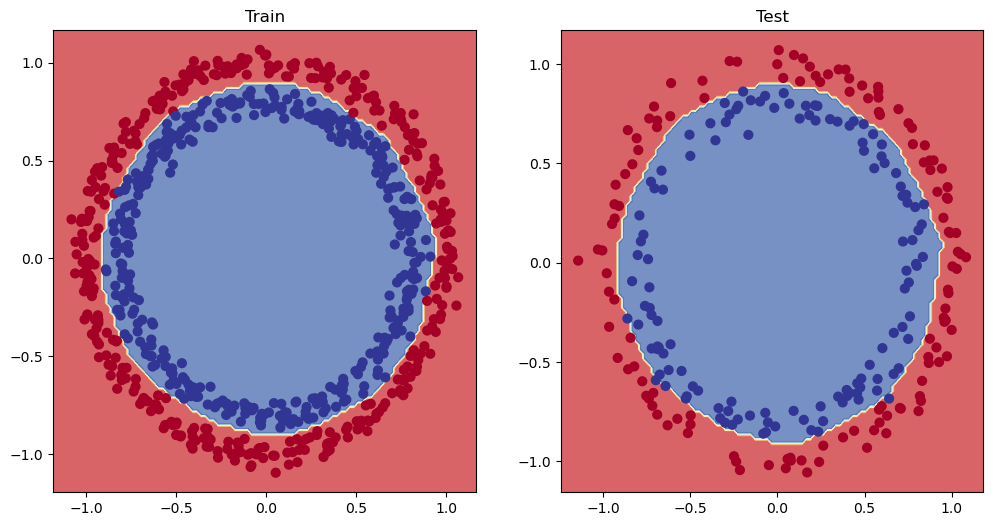

In [20]:
plt.figure(figsize=(12, 6)) 
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)

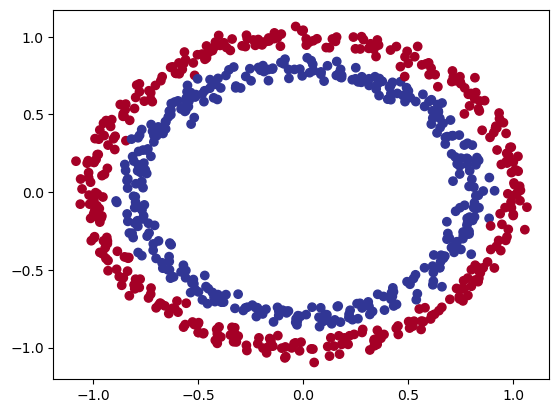

In [21]:
plot_circle_classification_selection(model, X_train, y_train)

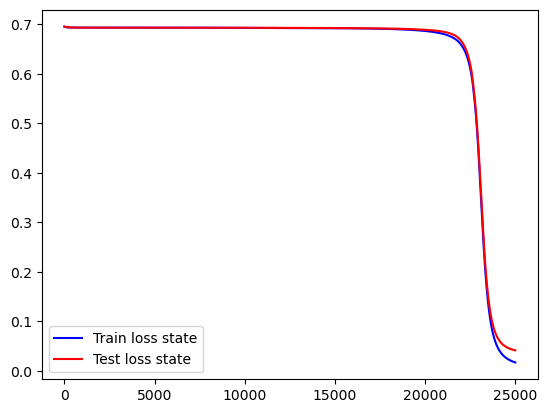

In [22]:
train_loss_count = torch.tensor(train_loss_count)
train_loss_count = np.array(train_loss_count)

test_loss_count = torch.tensor(test_loss_count)
test_loss_count = np.array(test_loss_count)

plt.plot(epoches_count, train_loss_count, color="blue", label="Train loss state")
plt.plot(epoches_count, test_loss_count, color="red", label="Test loss state")
plt.legend()

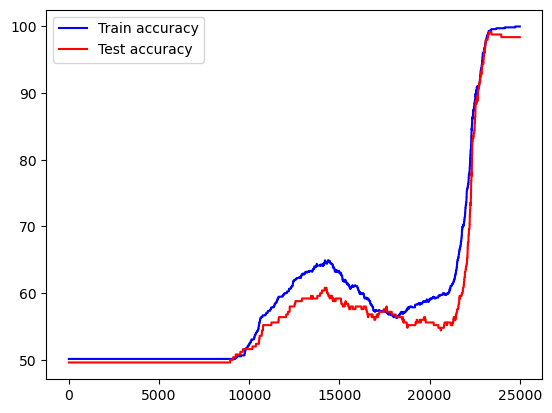

In [23]:
train_accuracy_count = torch.tensor(train_accuracy_count)
train_accuracy_count = np.array(train_accuracy_count)

test_accuracy_count = torch.tensor(test_accuracy_count)
test_accuracy_count = np.array(test_accuracy_count)

plt.plot(epoches_count, train_accuracy_count, color="blue", label="Train accuracy")
plt.plot(epoches_count, test_accuracy_count, color="red", label="Test accuracy")
plt.legend()